# Santa Tree Packing Optimization — Kaggle Competition.

This notebook is structured in CRISP-DM style and implements a fast, competitive solver for the Santa tree packing problem (Kaggle).

**What’s included:**
- Shapely-based geometry and collision checks
- Dense **hex lattice** initializers + rotation patterns
- **Global compression (binary search)** + **anisotropic square-aimed compression**
- Lightweight **polishers** (center pull / axis compaction / micro-rotation)
- **Adaptive schedules** based on number of trees `n`
- End-to-end solver for `n = 1..200`, rho diagnostics, and submission builder


## 0. Notebook Dependencies
If Shapely is missing in your environment, uncomment the install line below.

In [372]:
# Uncomment only if needed
# !pip -q install shapely

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext

from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
import warnings
warnings.filterwarnings("ignore")

## 1. Business Understanding

 Minimize the average square area per tree by optimally placing and rotating tree shapes inside the smallest possible square, across multiple configurations.

**Success Metric:**

$$ \text{Total Score} = \sum_{puzzles} \frac{s^2}{n} $$

Where:

$s$ = side length of minimal bounding square

$n$ = number of trees in that puzzle

**Hard Constraints:**

- No overlapping trees

- All trees must lie within coordinate bounds

- Output format must follow Kaggle spec

**Optimization Mindset:**

- Feasibility first, tightness second.


## 3. Modelling Assumptions
- Trees are 2D polygons.
- Rotation is allowed (degrees).
- The evaluator uses an **axis-aligned** bounding square.
- Touching edges is allowed; overlapping interiors is not.

⚠️ **Coordinate bounds:** Competition rules constrain x/y to a fixed range. Set `BOUNDS` accordingly.


In [439]:
# Coordinate bounds (UPDATE this to match the competition's metric notebook)
# Keeping a conservative default that works for most Kaggle packing puzzles.
BOUNDS = (-100.0, 100.0)

# Numerical tolerance
EPS = 1e-9

# Hex grid parameters (tuned values)
HEX_BASE_DEG_DEFAULT = np.float64(120.0) # degree
SPACING_SAFETY = 1.03        # or whatever your tuned value is
HEX_DY_MUL = 0.95           # tuned
HEX_ROW_OFFSET_MUL = 0.47   # tuned around 0.46–0.54 typically

## 4. Geometry Layer
### 4.1 Canonical Tree Polygon
We define one canonical tree polygon at the origin. All placements are transforms of this base shape.

This shape matches the multi-tier tree used in the Kaggle metric Evaluation

In [396]:
# Decimal precision and scaling factor
getcontext().prec = 25
scale_factor = Decimal('1')

class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))


BASE_TREE_POLY = ChristmasTree().polygon
BASE_TREE_POLY.is_valid, BASE_TREE_POLY.area


(True, 0.24562500000000004)

### 4.2 Transform Function
We **rotate about centroid**, then translate by `(x, y)`.

In [398]:
def transform_tree(base_polygon: Polygon, x: float, y: float, deg: float) -> Polygon:
    poly = affinity.rotate(base_polygon, deg, origin='centroid', use_radians=False)
    poly = affinity.translate(poly, xoff=x, yoff=y)
    return poly


### 4.3 Stateful Tree Representation
Each tree is stored as a dict:
- `x`, `y`, `deg`
- `poly` (Shapely geometry)

This makes it easy to debug and to generate submissions.

In [399]:
def make_tree_state(x: float, y: float, deg: float, base_polygon: Polygon = BASE_TREE_POLY) -> dict:
    return {
        'x': float(x),
        'y': float(y),
        'deg': float(deg),
        'poly': transform_tree(base_polygon, float(x), float(y), float(deg)),
    }

def rebuild_poly_inplace(t: dict, base_polygon: Polygon = BASE_TREE_POLY) -> None:
    t['poly'] = transform_tree(base_polygon, t['x'], t['y'], t['deg'])

def state_to_polys(state: list[dict]) -> list[Polygon]:
    return [t['poly'] for t in state]

def state_to_layout(state: list[dict]) -> list[tuple[float,float,float]]:
    return [(t['x'], t['y'], t['deg']) for t in state]

def rebuild_state_polys(state: list[dict], base_polygon: Polygon = BASE_TREE_POLY) -> None:
    """
    Rebuild shapely polygons for every tree dict in a state list.
    Matches the notebook's state structure: {'x','y','deg','poly'}.
    """
    for t in state:
        rebuild_poly_inplace(t, base_polygon)

## 5. Feasibility & Metric
### 5.1 Bounds Validation

In [400]:
def in_bounds(x: float, y: float, bounds=BOUNDS) -> bool:
    lo, hi = bounds
    return (lo <= x <= hi) and (lo <= y <= hi)

def validate_bounds_state(state: list[dict], bounds=BOUNDS) -> bool:
    for t in state:
        if not in_bounds(t['x'], t['y'], bounds=bounds):
            return False
    return True


### 5.2 Overlap Checking
We provide:
- A simple `O(n²)` overlap check (good for small n)
- A faster STRtree-based check (good for larger n)
- A local check for a single moved polygon


In [401]:
def overlaps(a: Polygon, b: Polygon) -> bool:
    # touching is allowed
    return a.intersects(b) and (not a.touches(b))

def has_overlap_pairwise(polys: list[Polygon]) -> bool:
    n = len(polys)
    for i in range(n):
        for j in range(i+1, n):
            if overlaps(polys[i], polys[j]):
                return True
    return False

def _strtree_hit_indices(tree: STRtree, geom: Polygon, idx_by_id: dict[int, int]) -> list[int]:
    # STRtree.query returns geometries (shapely<2) or indices (shapely>=2); normalize to indices.
    hits = tree.query(geom)
    if len(hits) == 0:
        return []
    first = hits[0]
    if isinstance(first, (int, np.integer)):
        return [int(i) for i in hits]
    return [idx_by_id[id(h)] for h in hits]

def has_overlap_strtree(polys: list[Polygon]) -> bool:
    if len(polys) < 2:
        return False
    tree = STRtree(polys)
    idx_by_id = {id(g): i for i, g in enumerate(polys)}
    for i, g in enumerate(polys):
        for j in _strtree_hit_indices(tree, g, idx_by_id):
            if j <= i:
                continue
            if overlaps(g, polys[j]):
                return True
    return False

def has_overlap_state(state: list[dict], method: str = 'auto') -> bool:
    polys = state_to_polys(state)
    if method == 'pairwise':
        return has_overlap_pairwise(polys)
    if method == 'strtree':
        return has_overlap_strtree(polys)
    # auto
    return has_overlap_strtree(polys) if len(polys) >= 80 else has_overlap_pairwise(polys)

def poly_overlaps_any(candidate: Polygon, polys: list[Polygon], skip_idx: int) -> bool:
    for j, other in enumerate(polys):
        if j == skip_idx:
            continue
        if overlaps(candidate, other):
            return True
    return False



### 5.3 Bounding Square and Score

In [402]:
def bounding_square_side_polys(polys: list[Polygon]) -> float:
    if not polys:
        return 0.0
    xmin, ymin, xmax, ymax = polys[0].bounds
    for p in polys[1:]:
        x0, y0, x1, y1 = p.bounds
        xmin = min(xmin, x0)
        ymin = min(ymin, y0)
        xmax = max(xmax, x1)
        ymax = max(ymax, y1)
    width = xmax - xmin
    height = ymax - ymin
    return float(max(width, height))

def bounding_dims_polys(polys: list[Polygon]) -> tuple[float,float]:
    if not polys:
        return (0.0, 0.0)
    xmin, ymin, xmax, ymax = polys[0].bounds
    for p in polys[1:]:
        x0, y0, x1, y1 = p.bounds
        xmin = min(xmin, x0)
        ymin = min(ymin, y0)
        xmax = max(xmax, x1)
        ymax = max(ymax, y1)
    return (float(xmax - xmin), float(ymax - ymin))

def score_state(state: list[dict]) -> float:
    n = len(state)
    if n == 0:
        return 0.0
    s = bounding_square_side_polys(state_to_polys(state))
    return (s*s) / n

def rho_state(state: list[dict]) -> float:
    # rho = s / sqrt(n)
    n = len(state)
    if n == 0:
        return 0.0
    s = bounding_square_side_polys(state_to_polys(state))
    return s / math.sqrt(n)


## 6. Placement Strategies
### 6.1 Spiral initializer (with inward-facing tips)

In [403]:
def spiral_positions(n: int, step: float = 2.0) -> list[tuple[float,float]]:
    x, y = 0.0, 0.0
    dx, dy = step, 0.0
    positions = [(x, y)]
    seg_len = 1
    while len(positions) < n:
        for _ in range(2):
            for _ in range(seg_len):
                if len(positions) >= n:
                    break
                x += dx
                y += dy
                positions.append((x, y))
            dx, dy = -dy, dx
        seg_len += 1
    return positions

def deg_inward(x: float, y: float, cx: float = 0.0, cy: float = 0.0) -> float:
    # direction from (x,y) to center
    theta = math.degrees(math.atan2(cy - y, cx - x))
    return theta - 90.0

def init_spiral_inward(n: int, step: float, base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    pos = spiral_positions(n, step=step)
    # center positions around origin
    mx = float(np.mean([p[0] for p in pos]))
    my = float(np.mean([p[1] for p in pos]))
    state = []
    for (x, y) in pos:
        x0, y0 = x - mx, y - my
        state.append(make_tree_state(x0, y0, deg_inward(x0, y0), base_polygon))
    return state


* Radial Initializer

In [404]:
def init_small_radial(n, radius, base_polygon=BASE_TREE_POLY):
    """
    Place trees on a circle, tips pointing inward.
    Great for n <= ~30.
    """
    if n == 1:
        return [make_tree_state(0.0, 0.0, 0.0, base_polygon)]

    st = []
    for i in range(n):
        theta = 2 * math.pi * i / n
        x = radius * math.cos(theta)
        y = radius * math.sin(theta)
        deg = math.degrees(math.atan2(-y, -x)) - 90.0
        st.append(make_tree_state(x, y, deg, base_polygon))
    return st



### 6.2 Hex (triangular) lattice initializer
This is a much denser starting point than spiral and is usually the biggest score improvement.


In [405]:
def hex_lattice_positions_compact(n: int, dx: float, dy: float, row_offset: float = 0.5):
    """
    Generate a hex/triangular lattice centered around 0 and select the n points
    that best fill a square-ish region (sorted by L∞ radius, then L2).
    Returns (x, y, i, j) where (i, j) are lattice indices for parity/orientation.
    """
    K = int(math.ceil(math.sqrt(n))) + 6  # plenty of points

    pts = []
    for j in range(-K, K + 1):
        y = j * dy
        off = (row_offset * dx) if (j % 2 != 0) else 0.0
        for i in range(-K, K + 1):
            x = i * dx + off
            pts.append((x, y, i, j))

    # Sort by square radius first (L∞), then by Euclidean as tiebreaker
    pts.sort(key=lambda t: (max(abs(t[0]), abs(t[1])), t[0]*t[0] + t[1]*t[1]))

    pts = pts[:n]

    # Center by mean (keeps it stable)
    mx = float(np.mean([p[0] for p in pts]))
    my = float(np.mean([p[1] for p in pts]))
    return [(x - mx, y - my, i, j) for (x, y, i, j) in pts]


def init_hex_alternating(n: int, dx: float, dy: float, row_offset: float, base_polygon=BASE_TREE_POLY):
    pts = hex_lattice_positions_compact(n, dx=dx, dy=dy, row_offset=row_offset)
    st = []
    for (x, y, i, j) in pts:
        deg = 0.0 if ((i + j) % 2 == 0) else 180.0
        st.append(make_tree_state(x, y, deg, base_polygon))
    return st


def init_hex_inward(n: int, dx: float, dy: float, row_offset: float, base_polygon=BASE_TREE_POLY):
    pts = hex_lattice_positions_compact(n, dx=dx, dy=dy, row_offset=row_offset)
    st = []
    for (x, y, i, j) in pts:
        # tip points toward (0,0)
        deg = math.degrees(math.atan2(-y, -x)) - 90.0
        st.append(make_tree_state(x, y, deg, base_polygon))
    return st



### 6.3 Hex alternating rotation families

* Try (0/180), (60/240), (120/300) as separate candidates.

In [440]:
def init_hex_alternating_offset(n: int, dx: float, dy: float, row_offset: float,
                               base_deg: HEX_BASE_DEG_DEFAULT,
                               base_polygon=BASE_TREE_POLY):
    """
    Hex lattice with 2-color alternating rotations, but with a base angle offset.
    base_deg=0 -> 0/180
    base_deg=60 -> 60/240
    base_deg=120 -> 120/300
    """
    pts = hex_lattice_positions_compact(n, dx=dx, dy=dy, row_offset=row_offset)
    st = []
    for (x, y, i, j) in pts:
        deg = base_deg if ((i + j) % 2 == 0) else (base_deg + 180.0)
        st.append(make_tree_state(x, y, deg, base_polygon))
    return st


## 7. Compression Layer (Big Win)
We apply **binary-search compression** to shrink layouts quickly:
- Global isotropic compression (same factor in x/y)
- Axis-only compression (x or y)
- A short loop to compress the **limiting axis** to better fit a square


In [407]:
def scale_state(state: list[dict], kx: float, ky: float, base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    # scale around mean position
    cx = float(np.mean([t['x'] for t in state])) if state else 0.0
    cy = float(np.mean([t['y'] for t in state])) if state else 0.0
    out = []
    for t in state:
        x = cx + (t['x'] - cx) * kx
        y = cy + (t['y'] - cy) * ky
        out.append(make_tree_state(x, y, t['deg'], base_polygon))
    return out

def feasible_state(state: list[dict], bounds=BOUNDS, overlap_method='auto') -> bool:
    if not validate_bounds_state(state, bounds=bounds):
        return False
    return not has_overlap_state(state, method=overlap_method)

def compress_global_bsearch(state: list[dict],
                           iters: int = 12,
                           lo: float = 0.20,
                           hi: float = 1.00,
                           bounds=BOUNDS,
                           overlap_method='auto',
                           base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    # hi should be feasible (current layout)
    best = state
    for _ in range(iters):
        mid = (lo + hi) / 2
        cand = scale_state(state, kx=mid, ky=mid, base_polygon=base_polygon)
        if feasible_state(cand, bounds=bounds, overlap_method=overlap_method):
            best = cand
            hi = mid
        else:
            lo = mid
    return best

def compress_axis_bsearch(state: list[dict],
                          axis: str,
                          iters: int = 10,
                          lo: float = 0.30,
                          hi: float = 1.00,
                          bounds=BOUNDS,
                          overlap_method='auto',
                          base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    best = state
    for _ in range(iters):
        mid = (lo + hi) / 2
        kx, ky = (mid, 1.0) if axis == 'x' else (1.0, mid)
        cand = scale_state(state, kx=kx, ky=ky, base_polygon=base_polygon)
        if feasible_state(cand, bounds=bounds, overlap_method=overlap_method):
            best = cand
            hi = mid
        else:
            lo = mid
    return best

def compress_to_square(state: list[dict],
                       rounds: int = 3,
                       axis_iters: int = 8,
                       bounds=BOUNDS,
                       overlap_method='auto',
                       base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = state
    for _ in range(rounds):
        w, h = bounding_dims_polys(state_to_polys(out))
        if w >= h + EPS:
            out = compress_axis_bsearch(out, axis='x', iters=axis_iters, bounds=bounds,
                                       overlap_method=overlap_method, base_polygon=base_polygon)
        elif h >= w + EPS:
            out = compress_axis_bsearch(out, axis='y', iters=axis_iters, bounds=bounds,
                                       overlap_method=overlap_method, base_polygon=base_polygon)
        else:
            break
    return out


## 8. Local Polishers (Lightweight)
After compression, we apply a small amount of local improvement. These are intentionally conservative to keep runtime reasonable.


### 8.1 Local movement and rotation

In [408]:
def try_move_inplace(state: list[dict], i: int, new_x: float, new_y: float,
                    base_polygon: Polygon = BASE_TREE_POLY) -> bool:
    # Save old
    t = state[i]
    old = (t['x'], t['y'], t['deg'], t['poly'])
    t['x'], t['y'] = float(new_x), float(new_y)
    rebuild_poly_inplace(t, base_polygon)

    # Bounds check
    if not in_bounds(t['x'], t['y']):
        t['x'], t['y'], t['deg'], t['poly'] = old
        return False

    polys = state_to_polys(state)
    if poly_overlaps_any(t['poly'], polys, skip_idx=i):
        t['x'], t['y'], t['deg'], t['poly'] = old
        return False
    return True

def try_rotate_inplace(state: list[dict], i: int, new_deg: float,
                      base_polygon: Polygon = BASE_TREE_POLY) -> bool:
    t = state[i]
    old = (t['x'], t['y'], t['deg'], t['poly'])
    t['deg'] = float(new_deg)
    rebuild_poly_inplace(t, base_polygon)
    polys = state_to_polys(state)
    if poly_overlaps_any(t['poly'], polys, skip_idx=i):
        t['x'], t['y'], t['deg'], t['poly'] = old
        return False
    return True


### 8.2 Center-pull polisher

In [409]:
def center_pull_polish(state: list[dict],
                      step: float = 0.05,
                      passes: int = 10,
                      base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = [dict(t) for t in state]
    for t in out:
        # Shapely geometries are immutable; shallow copy is fine.
        t['poly'] = t['poly']

    best_s = bounding_square_side_polys(state_to_polys(out))
    for _ in range(passes):
        cx = float(np.mean([t['x'] for t in out]))
        cy = float(np.mean([t['y'] for t in out]))
        moved_any = False
        for i, t in enumerate(out):
            vx, vy = (cx - t['x']), (cy - t['y'])
            norm = math.hypot(vx, vy)
            if norm < 1e-12:
                continue
            dx, dy = step * vx / norm, step * vy / norm
            old_xy = (t['x'], t['y'])
            ok = try_move_inplace(out, i, old_xy[0] + dx, old_xy[1] + dy, base_polygon)
            if not ok:
                continue
            new_s = bounding_square_side_polys(state_to_polys(out))
            if new_s <= best_s + 1e-9:
                best_s = new_s
                moved_any = True
            else:
                # revert if it made s worse
                try_move_inplace(out, i, old_xy[0], old_xy[1], base_polygon)
        if not moved_any:
            break
    return out



### 8.3 Axis inward compaction (few steps per tree)

In [410]:
def axis_inward_compaction(state: list[dict],
                           axis: str,
                           step: float = 0.05,
                           max_steps_per_tree: int = 5,
                           base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = [dict(t) for t in state]
    for t in out:
        t['poly'] = t['poly']

    polys = state_to_polys(out)
    xmin, ymin, xmax, ymax = polys[0].bounds
    for p in polys[1:]:
        x0, y0, x1, y1 = p.bounds
        xmin, ymin = min(xmin, x0), min(ymin, y0)
        xmax, ymax = max(xmax, x1), max(ymax, y1)
    cx = (xmin + xmax) / 2
    cy = (ymin + ymax) / 2

    best_s = bounding_square_side_polys(polys)

    # sort by coordinate so outer trees get a chance to move in
    key = (lambda t: t['x']) if axis == 'x' else (lambda t: t['y'])
    order = sorted(range(len(out)), key=lambda i: key(out[i]))

    for i in order:
        for _ in range(max_steps_per_tree):
            t = out[i]
            if axis == 'x':
                direction = -1.0 if t['x'] > cx else 1.0
                new_x, new_y = t['x'] + direction * step, t['y']
            else:
                direction = -1.0 if t['y'] > cy else 1.0
                new_x, new_y = t['x'], t['y'] + direction * step

            old_xy = (t['x'], t['y'])
            if not try_move_inplace(out, i, new_x, new_y, base_polygon):
                break
            new_s = bounding_square_side_polys(state_to_polys(out))
            if new_s <= best_s + 1e-9:
                best_s = new_s
            else:
                # revert and stop trying this direction
                try_move_inplace(out, i, old_xy[0], old_xy[1], base_polygon)
                break
    return out

def axis_compaction_polish(state: list[dict],
                           step: float = 0.05,
                           max_steps_per_tree: int = 5,
                           base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = axis_inward_compaction(state, axis='x', step=step, max_steps_per_tree=max_steps_per_tree, base_polygon=base_polygon)
    out = axis_inward_compaction(out, axis='y', step=step, max_steps_per_tree=max_steps_per_tree, base_polygon=base_polygon)
    return out


### 8.4 Rotation micro-optimization (small angle trials)

In [411]:
def rotation_micro_polish(state: list[dict],
                          angle_steps: tuple[int,...] = (-5, -2, -1, 1, 2, 5),
                          max_passes: int = 2,
                          base_polygon: Polygon = BASE_TREE_POLY) -> list[dict]:
    out = [dict(t) for t in state]
    for t in out:
        t['poly'] = t['poly']

    best_s = bounding_square_side_polys(state_to_polys(out))
    for _ in range(max_passes):
        improved = False
        for i, t in enumerate(out):
            old_deg = t['deg']
            for d in angle_steps:
                if not try_rotate_inplace(out, i, old_deg + d, base_polygon):
                    continue
                new_s = bounding_square_side_polys(state_to_polys(out))
                if new_s < best_s - 1e-9:
                    best_s = new_s
                    improved = True
                    break
                else:
                    # revert
                    try_rotate_inplace(out, i, old_deg, base_polygon)
            if improved:
                break
        if not improved:
            break
    return out


### 8.5 Recompress after polish

After local moves, we run a short global compression + square-aim again to remove any slack introduced by polishers.

In [412]:
def recompress_after_polish(state, base_poly, bsearch_iters=8, square_rounds=2):
    # short global compress
    state = compress_global_bsearch(state, base_polygon=base_poly, iters=bsearch_iters)
    # square-aimed anisotropic compress
    state = compress_to_square(state, base_polygon=base_poly, rounds=square_rounds)
    return state


### 8.6 Global rotation sweep

Rotate the whole layout by a few angles and keep the one that minimizes the square bounding side.

In [413]:
def rotate_state_global(state, deg, base_poly):
    # rotate around centroid of positions
    cx = float(np.mean([t["x"] for t in state]))
    cy = float(np.mean([t["y"] for t in state]))
    ang = math.radians(deg)

    new_state = []
    for t in state:
        x, y = t["x"] - cx, t["y"] - cy
        xr = x*math.cos(ang) - y*math.sin(ang)
        yr = x*math.sin(ang) + y*math.cos(ang)
        new_state.append({
            "x": xr + cx,
            "y": yr + cy,
            "deg": t["deg"] + deg,
            "poly": None
        })
    rebuild_state_polys(new_state, base_poly)
    return new_state

def best_global_rotation(state, base_poly, angles=(0, 10, 20, 30, 40, 45)):
    best = state
    best_score = score_state(best)
    for a in angles:
        cand = rotate_state_global(state, a, base_poly)
        sc = score_state(cand)
        if sc < best_score:
            best, best_score = cand, sc
    return best


## 9. Adaptive Schedules (Based on n)
We spend more compute on small puzzles, and keep big `n` fast.


In [447]:
def schedule_for_n(n: int) -> dict:
    # Small n
    if n <= 20:
        return {
        "candidates": ["small_radial", "hex_alt0", "hex_alt60", "hex_alt120", "hex_inward"],
        "compress_iters": 16,
        "aniso_rounds": 3,
        'aniso_axis_iters': 8,
        'center_step': 0.05,
        'axis_step': 0.05,
        "center_passes": 10,
        "axis_steps_per_tree": 6,
        "rot_passes": 3,
        "rot_steps": (-5, -2, -1, 1, 2, 5),
        "do_global_rotation": True
        }
    # Medium n
    if n <= 80:
        return {
            "candidates" : ["hex_alt120", "hex_alt60", "hex_inward"],
            'compress_iters': 12,
            'aniso_rounds': 3,
            'aniso_axis_iters': 8,
            'center_step': 0.05,
            'center_passes': 8,
            'axis_step': 0.05,
            'axis_steps_per_tree': 5,
            'rot_passes': 2,
            'rot_steps': (-3, -1, 1, 3),
            'do_global_rotation': True,
        }
    # Large n
    return {
        'candidates': ['hex_alt120', 'hex_alt60', 'hex_alt0', 'hex_inward'],
        'compress_iters': 10,
        'aniso_rounds': 2,
        'aniso_axis_iters': 6,
        'center_step': 0.05,
        'center_passes': 3,
        'axis_step': 0.05,
        'axis_steps_per_tree': 3,
        'rot_passes': 1,
        'rot_steps': (-2, 2),
        'do_global_rotation': True,
    }


In [415]:
def schedule_fast(n: int) -> dict:
    s = schedule_for_n(n).copy()
    # keep it cheap
    s['compress_iters'] = min(s['compress_iters'], 10)
    s['aniso_rounds'] = min(s['aniso_rounds'], 2)
    s['center_passes'] = min(s['center_passes'], 4)
    s['axis_steps_per_tree'] = min(s['axis_steps_per_tree'], 3)
    s['rot_passes'] = 0  # biggest runtime saver
    # candidates: minimal
    s['candidates'] = ['hex_alt0', 'hex_inward', 'hex_alt60', 'hex_alt120'] if n > 25 else ['hex_alt0', 'hex_inward', 'hex_alt60', 'small_radial']
    return s

def schedule_heavy(n: int) -> dict:
    s = schedule_for_n(n).copy()
    # spend a bit more
    s['compress_iters'] = max(s['compress_iters'], 14)
    s['aniso_rounds'] = max(s['aniso_rounds'], 3)
    s['center_passes'] = max(s['center_passes'], 8)
    s['axis_steps_per_tree'] = max(s['axis_steps_per_tree'], 5)
    s['rot_passes'] = max(s['rot_passes'], 2)
    # candidates: more variety
    s['candidates'] = ['hex_alt0', 'hex_alt60', 'hex_inward', 'hex_alt120'] if n <= 120 else ['hex_alt0', 'hex_alt60', 'hex_inward', 'hex_alt120', 'spiral']
    return s


## 10. Solver (Single n)
For each `n`, we:
1. Generate multiple candidate layouts (multi-start)
2. Compress globally (binary search)
3. Compress the limiting axis to square-ify
4. Apply lightweight polishers
5. Pick the best


### 10.1 N-th Puzzle solver

In [434]:
def default_hex_spacing(base_polygon: Polygon = BASE_TREE_POLY, safety: float = 1.15) -> tuple[float,float,float]:
    # conservative spacing based on bounding box
    minx, miny, maxx, maxy = base_polygon.bounds
    w = maxx - minx
    h = maxy - miny
    dx = max(w, h) * SPACING_SAFETY
    dy = dx * (math.sqrt(3)/2) * HEX_DY_MUL
    row_offset = 0.5 * HEX_ROW_OFFSET_MUL
    return float(dx), float(dy), float(row_offset)

def build_candidates(n: int, sched: dict, base_polygon: Polygon = BASE_TREE_POLY) -> list[tuple[str, list[dict]]]:
    dx, dy, row_offset = default_hex_spacing(base_polygon)
    spiral_step = dx

    out = []
    for name in sched['candidates']:
        if name == 'hex_alt':
            out.append((name, init_hex_alternating(n, dx=dx, dy=dy, row_offset=row_offset, base_polygon=base_polygon)))

        elif name == 'hex_alt0':
            out.append((name, init_hex_alternating_offset(n, dx=dx, dy=dy, row_offset=row_offset,
                                                          base_deg=0.0, base_polygon=base_polygon)))
        elif name == 'hex_alt60':
            out.append((name, init_hex_alternating_offset(n, dx=dx, dy=dy, row_offset=row_offset,
                                                          base_deg=60.0, base_polygon=base_polygon)))
        elif name == 'hex_alt120':
            out.append((name, init_hex_alternating_offset(n, dx=dx, dy=dy, row_offset=row_offset,
                                                          base_deg=120.0, base_polygon=base_polygon)))

        elif name == 'hex_inward':
            out.append((name, init_hex_inward(n, dx=dx, dy=dy, row_offset=row_offset, base_polygon=base_polygon)))

        elif name == "small_radial":
            out.append((name, init_small_radial(n, radius=dx, base_polygon=base_polygon)))

        elif name == 'spiral':
            out.append((name, init_spiral_inward(n, step=spiral_step, base_polygon=base_polygon)))

        else:
            raise ValueError(f"Unknown candidate '{name}'")
    return out


def solve_single_n(n: int,
                  base_polygon: Polygon = BASE_TREE_POLY,
                  bounds=BOUNDS,
                  verbose: bool = False,
                  sched: dict | None = None) -> tuple[list[dict], dict]:

    sched = schedule_for_n(n) if sched is None else sched

    overlap_method = 'strtree' if n >= 80 else 'pairwise'
    candidates = build_candidates(n, sched, base_polygon)

    best_state = None
    best_score = float('inf')
    best_meta = {}

    for name, st0 in candidates:
        # 1) Global compression
        st = compress_global_bsearch(
            st0,
            iters=sched['compress_iters'],
            lo=0.20,
            hi=1.00,
            bounds=bounds,
            overlap_method=overlap_method,
            base_polygon=base_polygon,
        )
        # 2) Square-aimed anisotropic compression
        st = compress_to_square(
            st,
            rounds=sched['aniso_rounds'],
            axis_iters=sched['aniso_axis_iters'],
            bounds=bounds,
            overlap_method=overlap_method,
            base_polygon=base_polygon,
        )
        # 3) Light polishers
        st = center_pull_polish(st, step=sched['center_step'], passes=sched['center_passes'], base_polygon=base_polygon)
        st = axis_compaction_polish(st, step=sched['axis_step'], max_steps_per_tree=sched['axis_steps_per_tree'], base_polygon=base_polygon)
        if sched['rot_passes'] > 0:
            st = rotation_micro_polish(st, angle_steps=sched['rot_steps'], max_passes=sched['rot_passes'], base_polygon=base_polygon)

        # Recompress after polishing
        st = recompress_after_polish(st, base_polygon, bsearch_iters=8, square_rounds=2)

        st = best_global_rotation(st, base_polygon, angles = tuple(range(0, 46, 5)) if n <= 50 else (0, 15, 30, 45)
)
        # Optional: one more short square-aim after rotation
        st = compress_to_square(st, base_polygon=base_polygon, overlap_method=overlap_method)

        # Global rotation search
        angles = tuple(range(0, 46, 5)) if n <= 60 else (0, 15, 30, 45)
        st = best_global_rotation(st, base_poly=base_polygon, angles=angles)
        
        # Final square-aimed compression
        st = compress_to_square(st, base_polygon=base_polygon, overlap_method=overlap_method)

        # 4) Final feasibility check
        if not feasible_state(st, bounds=bounds, overlap_method=overlap_method):
            if verbose:
                print(f"[WARN] Candidate {name} produced infeasible layout at n={n}")
            continue

        sc = score_state(st)
        if sc < best_score:
            best_score = sc
            best_state = st
            best_meta = {
                'n': n,
                'candidate': name,
                'score_n': sc,
                'rho': math.sqrt(sc),
                's': bounding_square_side_polys(state_to_polys(st)),
            }

    if best_state is None:
        # fallback to spiral with safe spacing
        dx, dy, _ = default_hex_spacing(base_polygon)
        best_state = init_spiral_inward(n, step=dx, base_polygon=base_polygon)
        best_state = compress_global_bsearch(best_state, iters=10, bounds=bounds, overlap_method=overlap_method, base_polygon=base_polygon)
        best_meta = {
            'n': n,
            'candidate': 'fallback_spiral',
            'score_n': score_state(best_state),
            'rho': rho_state(best_state),
            's': bounding_square_side_polys(state_to_polys(best_state)),
        }
    

    return best_state, best_meta


### 10.2 Hyperparameter tuning

In [431]:
def eval_hex_params(n_list, dy_muls, row_muls, base_degs, base_polygon=BASE_TREE_POLY):
    base_dx, base_dy, base_row = default_hex_spacing(base_polygon)

    rows = []
    for base_deg in base_degs:
        for dym in dy_muls:
            for rom in row_muls:
                scores = []
                for n in n_list:
                    dx = base_dx
                    dy = base_dy * dym
                    row_offset = base_row * rom

                    st = init_hex_alternating_offset(
                        n, dx=dx, dy=dy, row_offset=row_offset,
                        base_deg=base_deg, base_polygon=base_polygon
                    )

                    # just compression + square aim (fast + stable for tuning)
                    st = compress_global_bsearch(st, iters=12, base_polygon=base_polygon)
                    st = compress_to_square(st, rounds=2, base_polygon=base_polygon)

                    scores.append(score_state(st))

                rows.append({
                    "base_deg": base_deg,
                    "dy_mul": dym,
                    "row_mul": rom,
                    "avg_score": float(np.mean(scores)),
                    "max_score": float(np.max(scores)),
                })

    return pd.DataFrame(rows).sort_values("avg_score")


# Tune on the regime that dominates your total
n_list = [10, 40, 70, 100, 120, 150, 180, 200]
dy_muls = np.arange(0.80, 1.21, 0.05).tolist()  # multiplier on your current dy baseline
row_muls = [0.90, 1.00, 1.10, 1.15, 1.20]     # multiplier on your current row_offset baseline
base_degs = [0.0, 60.0, 120.0]

df_tune = eval_hex_params(n_list, dy_muls, row_muls, base_degs)


In [432]:
print(df_tune.head(10))


     base_deg  dy_mul  row_mul  avg_score  max_score
105     120.0    0.95      0.9   0.568418   0.629302
60       60.0    0.95      0.9   0.580040   0.679548
34        0.0    1.10      1.2   0.581621   0.771675
100     120.0    0.90      0.9   0.583682   0.666340
39        0.0    1.15      1.2   0.585374   0.757325
115     120.0    1.05      0.9   0.589429   0.665324
110     120.0    1.00      0.9   0.592063   0.672245
106     120.0    0.95      1.0   0.592852   0.656423
44        0.0    1.20      1.2   0.595868   0.730984
70       60.0    1.05      0.9   0.597519   0.719172


## 11. Solve All (n = 1..200) + Rho Diagnostics
This implements the competition requirement: solve every `n` and sum the normalized scores.


### 11.1 Baseline Solver

In [371]:
def solve_all_1_to_200(max_n: int = 200,
                      base_polygon: Polygon = BASE_TREE_POLY,
                      bounds=BOUNDS,
                      verbose_every: int = 25) -> tuple[dict, pd.DataFrame, float]:
    layouts = {}
    rows = []
    total = 0.0
    for n in range(1, max_n + 1):
        st, meta = solve_single_n(n, base_polygon=base_polygon, bounds=bounds, verbose=False)
        layouts[f"{n:03d}"] = state_to_layout(st)
        total += meta['score_n']
        rows.append(meta)
        if verbose_every and (n % verbose_every == 0 or n == max_n):
            print(f"Done n={n:03d} | cumulative={total:.4f} | last candidate={meta['candidate']} | last score={meta['score_n']:.4f}")
    df = pd.DataFrame(rows)
    return layouts, df, float(total)

def add_rho_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # rho = s / sqrt(n) ; also rho = sqrt(score_n)
    out['rho_check'] = np.sqrt(out['score_n'])
    return out


### 11.2 Adaptive solver

In [435]:
def solve_all_two_pass(max_n: int = 200,
                       worst_k: int = 25,
                       base_polygon: Polygon = BASE_TREE_POLY,
                       bounds=BOUNDS,
                       verbose_every: int = 25):
    layouts = {}
    rows = []

    # Pass 1: fast everywhere
    cumulative = 0.0
    for n in range(1, max_n + 1):
        st, meta = solve_single_n(n, base_polygon=base_polygon, bounds=bounds,
                                  sched=schedule_fast(n))
        layouts[f"{n:03d}"] = state_to_layout(st)
        rows.append(meta)
        cumulative += meta['score_n']

        if n % verbose_every == 0:
            print(f"Done n={n:03d} | cumulative={cumulative:.4f} | last candidate={meta['candidate']} | last score={meta['score_n']:.4f}")

    df = pd.DataFrame(rows).sort_values("n").reset_index(drop=True)

    # pick worst n’s to redo with heavy schedule
    worst_ns = df.sort_values("score_n", ascending=False).head(worst_k)["n"].tolist()
    focus_band = df[(df["n"] >= 21) & (df["n"] <= 50)].sort_values("score_n", ascending=False).head(15)["n"].tolist()
    worst_ns = sorted(set(worst_ns + focus_band))

    # Pass 2: heavy only for the worst
    for n in worst_ns:
        st, meta = solve_single_n(n, base_polygon=base_polygon, bounds=bounds,
                                  sched=schedule_heavy(n))
        layouts[f"{n:03d}"] = state_to_layout(st)
        df.loc[df["n"] == n, df.columns] = pd.Series(meta)

    df["rho"] = np.sqrt(df["score_n"])

    df = df.sort_values("n").reset_index(drop=True)
    total = float(df["score_n"].sum())
    return layouts, df, total



## 12. Submission Builder
Kaggle expects:
- `id` like `001_0`, `001_1`, …
- `x`, `y`, `deg` stored as strings, prefixed with `s`


In [310]:
def fmt(v: float) -> str:
    return f"s{float(v):.6f}"

def build_submission_df(layouts: dict) -> pd.DataFrame:
    rows = []
    for pid, layout in layouts.items():
        for i, (x, y, deg) in enumerate(layout):
            rows.append({
                'id': f"{pid}_{i}",
                'x': fmt(x),
                'y': fmt(y),
                'deg': fmt(deg),
            })
    return pd.DataFrame(rows)

def build_submission_from_sample(sample_df: pd.DataFrame, layouts: dict) -> pd.DataFrame:
    # Ensures exact row order matches Kaggle sample_submission
    out = sample_df.copy()
    xs, ys, ds = [], [], []
    for _id in out['id'].tolist():
        pid, idx = _id.split('_')
        idx = int(idx)
        x, y, deg = layouts[pid][idx]
        xs.append(fmt(x))
        ys.append(fmt(y))
        ds.append(fmt(deg))
    out['x'] = xs
    out['y'] = ys
    out['deg'] = ds
    return out


## 13. Visualization Utilities (Debugging)
Plot a layout for a given n to visually confirm packing and bounding square.


In [311]:
def plot_layout_layout(layout: list[tuple[float,float,float]], base_polygon: Polygon = BASE_TREE_POLY, show_square: bool = True):
    polys = [transform_tree(base_polygon, x, y, deg) for x, y, deg in layout]
    fig, ax = plt.subplots(figsize=(6, 6))
    for p in polys:
        x, y = p.exterior.xy
        ax.fill(x, y, alpha=0.6, edgecolor='black')
    if show_square and polys:
        s = bounding_square_side_polys(polys)
        xmin, ymin, xmax, ymax = polys[0].bounds
        for p in polys[1:]:
            x0, y0, x1, y1 = p.bounds
            xmin, ymin = min(xmin, x0), min(ymin, y0)
            xmax, ymax = max(xmax, x1), max(ymax, y1)
        # square anchored at (xmin, ymin)
        ax.plot([xmin, xmin+s, xmin+s, xmin, xmin], [ymin, ymin, ymin+s, ymin+s, ymin], 'r--')
    ax.set_aspect('equal')
    plt.show()


## 14. Quick Sanity Check (Before Full Run)
Run a small `n` test, check overlap, and visualize.


{'n': 73, 'candidate': 'hex_alt120', 'score_n': 0.6351652940996854, 'rho': 0.7969725805193585, 's': 6.809336712872777}
Overlap? False
Score_n: 0.6351652940996854


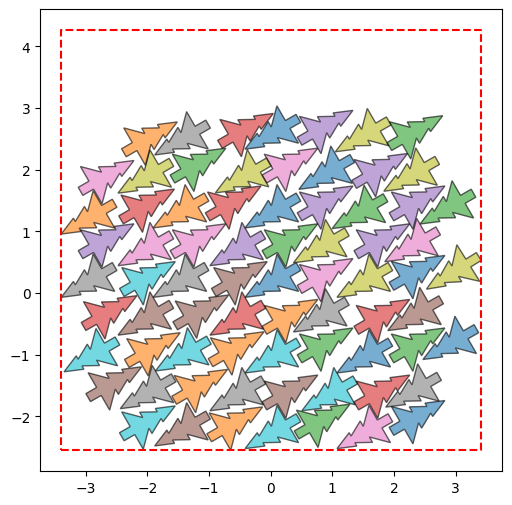

In [449]:
n_test = 73
st, meta = solve_single_n(n_test)
print(meta)
print('Overlap?', has_overlap_state(st, method='pairwise'))
print('Score_n:', score_state(st))
plot_layout_layout(state_to_layout(st))


## 15. Full Run: Solve n=1..200, Compute Total Score, Build Submission
⚠️ This can take a while depending on your environment. Start by running `max_n=50` to validate end-to-end.

After generating `submission.csv`, upload it to Kaggle.


In [442]:
# Example: start small
max_n = 200
layouts, df, total = solve_all_two_pass(max_n=max_n, worst_k=15, verbose_every=10)
print(f"Total (1..{max_n}):", total)
print(df.sort_values("score_n", ascending=False).head(10)[["n","candidate","score_n","rho","s"]])

# Full run
#layouts, df, total = solve_all_two_pass(max_n=200, verbose_every=25)
#df = add_rho_columns(df)
#print('TOTAL (1..200):', total)
#display(df.sort_values('score_n', ascending=False).head(10))

#sub = build_submission_df(layouts)
#sub.to_csv('submission.csv', index=False)
#sub.head()



Done n=010 | cumulative=6.2082 | last candidate=small_radial | last score=0.5932
Done n=020 | cumulative=12.7547 | last candidate=hex_alt60 | last score=0.6769
Done n=030 | cumulative=19.1563 | last candidate=hex_alt60 | last score=0.6182
Done n=040 | cumulative=24.9504 | last candidate=hex_alt60 | last score=0.5592
Done n=050 | cumulative=31.0927 | last candidate=hex_alt60 | last score=0.5617
Done n=060 | cumulative=36.5649 | last candidate=hex_alt120 | last score=0.5120
Done n=070 | cumulative=42.0621 | last candidate=hex_alt120 | last score=0.6501
Done n=080 | cumulative=48.2219 | last candidate=hex_alt120 | last score=0.5805
Done n=090 | cumulative=53.6596 | last candidate=hex_alt60 | last score=0.5160
Done n=100 | cumulative=58.9393 | last candidate=hex_alt60 | last score=0.5945
Done n=110 | cumulative=64.7186 | last candidate=hex_alt120 | last score=0.5796
Done n=120 | cumulative=70.2453 | last candidate=hex_alt120 | last score=0.5318
Done n=130 | cumulative=75.5564 | last candid

## 16. Diagnostics & Debugging

In [443]:
# Summarize average score by bins
bins = [0, 20, 50, 100, 150, 200]
labels = ["1-20", "21-50", "51-100", "101-150", "151-200"]
df["bin"] = pd.cut(df["n"], bins=bins, labels=labels, include_lowest=True)

summary = df.groupby("bin")["score_n"].agg(["count", "mean", "sum", "max"]).reset_index()
print(summary)


       bin  count      mean        sum       max
0     1-20     10  0.576916   5.769161  0.652105
1    21-50     15  0.581161   8.717421  0.605635
2   51-100     49  0.554841  27.187199  0.654077
3  101-150     50  0.540449  27.022432  0.588581
4  151-200     50  0.526667  26.333374  0.559028


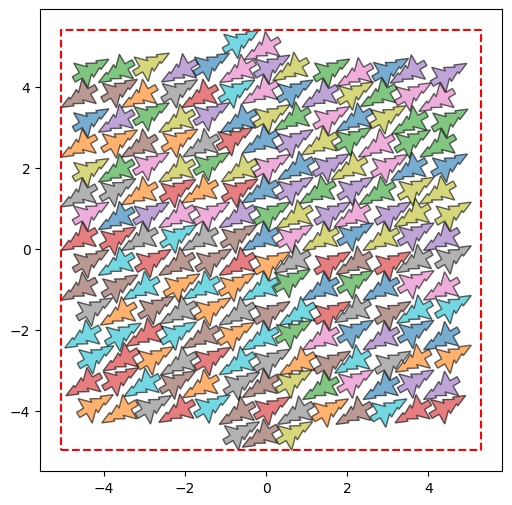

In [444]:
plot_layout_layout(layouts['200'], show_square=True)